# Basic LSTM example for DS@HEP hands-on

**TODO** Add a description up here.

**TODO** Drop unnecessary pandas and use numpy directly

In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib notebook

### Loading the data

Change this to point to whichever dataset you want to use.

In [2]:
filename = "public_train.csv"
df = pd.read_csv(filename)

In [3]:
# Build the arrays of input variables and track labels (cluster_id)
# by dropping everything else from the dataframe with a call to drop
y = df.drop(['layer','iphi','x','y'], axis=1).values
X = df.drop(['cluster_id'], axis=1).values

### Looping over events

In [4]:
y_events = y[:,0]
events = np.unique(y_events)

# Count the number of tracks
ntrack = 0
for ev in events:
    ntrack += np.unique(y[y_events==ev][:,1]).size

In [5]:
print('There are %d events' % events.shape[0])
print('There are %d total tracks' % ntrack)
print('There are %d total hits' % X.shape[0])
print('Average %g hits per track' % (float(X.shape[0]) / ntrack))
print('There are %d hits on first layer' % X[X[:,1]==0].shape[0])
print('There are %d hits on last layer' % X[X[:,1]==8].shape[0])

There are 5000 events
There are 49897 total tracks
There are 418059 total hits
Average 8.37844 hits per track
There are 48383 hits on first layer
There are 44654 hits on last layer


In [6]:
# Pick out one event for later inspection
ievent = 3
event_indices = X[:,0]==ievent
X_event = X[event_indices,1:] # event_id column dropped
pixelx = X_event[:,2]
pixely = X_event[:,3]
particles = y[event_indices][:,1]

### Define the model

In [7]:
from sklearn.base import BaseEstimator
from sklearn.cluster import DBSCAN

from keras import layers, models

Using Theano backend.


In [8]:
class det_geo():
    layer_r = np.array([39,85,155,213,271,405,562,762,1000])
    layer_pitch = np.array([0.025, 0.025, 0.025, 0.025, 0.025,
                            0.05, 0.05, 0.05, 0.05])
    num_layers = layer_r.shape[0]
    max_phi = (2 * np.pi * layer_r / layer_pitch + 1).astype(np.int)

def rescale_phi(phi, nbin, layer):
    return (phi * float(nbin) /
            det_geo.max_phi[layer.astype(np.int)]).astype(np.int)

def build_model(num_hidden, length, dim,
                loss='categorical_crossentropy',
                optimizer='Nadam', metrics=['accuracy']):
    inputs = layers.Input(shape=(length, dim))
    hidden = layers.LSTM(output_dim=num_hidden, return_sequences=True)(inputs)
    outputs = layers.TimeDistributed(layers.Dense(dim, activation='softmax'))(hidden)
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [13]:
class Clusterer(BaseEstimator):
    def __init__(self, num_phi_bin=100, hidden_dim=50, batch_size=128, num_epoch=5):
        """
        LSTM model example.
        TODO: fill in more details.
        """
        self.num_phi_bin = num_phi_bin
        self.hidden_dim = hidden_dim
        self.model = build_model(self.hidden_dim,
                                 det_geo.layer_r.shape[0],
                                 self.num_phi_bin)
        self.batch_size = batch_size
        self.num_epoch = num_epoch

    def fit(self, X, y):
        evids, layers, phis = (X[:,0].astype(np.int),
                               X[:,1].astype(np.int),
                               X[:,2].astype(np.int))
        phis = rescale_phi(phis, self.num_phi_bin, layers)
        unique_evids = np.unique(evids)
        num_event = unique_evids.shape[0]

        # Count the number of first-layer hits, which will be my seeds
        seed_idx = np.where(layers == 0)[0]
        num_seeds = seed_idx.size
        print('Number of seeds: %d' % num_seeds)

        print('Preparing training data...')
        # Training input will contain the seed hit followed by the rest of the event
        self.train_input = np.zeros((num_seeds, det_geo.num_layers,
                                     self.num_phi_bin))
        # Training targets will be images of the individual signal tracks
        self.train_target = np.zeros_like(self.train_input)

        # Loop over training samples to prepare (seeds)
        for i_sample in xrange(num_seeds):
            i_hit = seed_idx[i_sample]

            # Find all the hits from this event
            ev_idx = evids == y[i_hit,0]
            ev_lay, ev_phi = layers[ev_idx], phis[ev_idx]

            # Fill the input first layer with just the seed hit
            self.train_input[i_sample,0,phis[i_hit]] = 1
            # Fill the other layers with all remaining event hits
            self.train_input[i_sample, ev_lay[ev_lay>0], ev_phi[ev_lay>0]] = 1

            # Fill target with hits from this track
            ev_trkid = y[ev_idx][:,1]
            ev_trk_idx = ev_trkid == y[i_hit,1]
            self.train_target[i_sample, ev_lay[ev_trk_idx], ev_phi[ev_trk_idx]] = 1

        print('Starting training...')
        self.history = self.model.fit(
            self.train_input, self.train_target,
            batch_size=self.batch_size, nb_epoch=self.num_epoch)

    def predict_single_event(self, X_event):

        # We need to now transform the data into the format
        # needed for my algorithm
        lays, phis = (X_event[:,0].astype(np.int),
                      X_event[:,1].astype(np.int))
        # Rebin phi
        phis = rescale_phi(phis, self.num_phi_bin, lays)

        # First, find the seeds
        seed_idx = np.where(lays == 0)[0]
        num_seeds = seed_idx.size

        # Prepare the model inputs
        self.test_input = np.zeros((num_seeds, det_geo.num_layers,
                                    self.num_phi_bin))

        # Loop over seeds to prepare
        for i_sample in xrange(num_seeds):
            i_hit = seed_idx[i_sample]

            # Fill the input first layer with just the seed hit
            self.test_input[i_sample, 0, phis[i_hit]] = 1
            # Fill the other layers with all remaining event hits
            self.test_input[i_sample, lays[lays>0], phis[lays>0]] = 1

        # Run the model prediction
        self.test_pred = self.model.predict(self.test_input)

        # Now we need to loop over all hits and decide which
        # track they belong to
        trkid = np.zeros(X_event.shape[0])
        for i in xrange(trkid.shape[0]):
            lay, phi = lays[i], phis[i]

            # Get the list of track scores
            scores = self.test_pred[:, lays[i], phis[i]]
            #print 'scores:', scores

            # Select the best score
            best = np.argmax(scores)

            # If the best isn't good enough, it's possible that
            # a track was missing a hit on the first layer.
            # We may be able to improve score by assigning all such
            # tracks to a new class (rather than 'unassigned')
            if scores[best] < 1 / float(self.num_phi_bin):
                best = scores.shape[0]

            trkid[i] = best

        return trkid

In [14]:
tracker = Clusterer()

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=50, return_sequences=True)`
  app.launch_new_instance()
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Reshape{3}..., inputs=/input_2)`


#### Training the algorithm

In [15]:
tracker.fit(X, y)

Number of seeds: 48383
Preparing training data...
Starting training...


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:56: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/5
48383/48383 [==============================] - 10s - loss: 3.3093 - acc: 0.3411    
Epoch 2/5
48383/48383 [==============================] - 10s - loss: 1.8246 - acc: 0.6055    
Epoch 3/5
48383/48383 [==============================] - 11s - loss: 1.2136 - acc: 0.6691    
Epoch 4/5
48383/48383 [==============================] - 11s - loss: 0.9857 - acc: 0.6862    
Epoch 5/5
48383/48383 [==============================] - 11s - loss: 0.8301 - acc: 0.7072    


#### Running the algorithm to reconstruct the tracks in data
This will take some time to go through all events

In [16]:
y_true = y
y_predicted = tracker.predict_single_event(X_event)

In [17]:
tracks = y_predicted

<IPython.core.display.Javascript object>


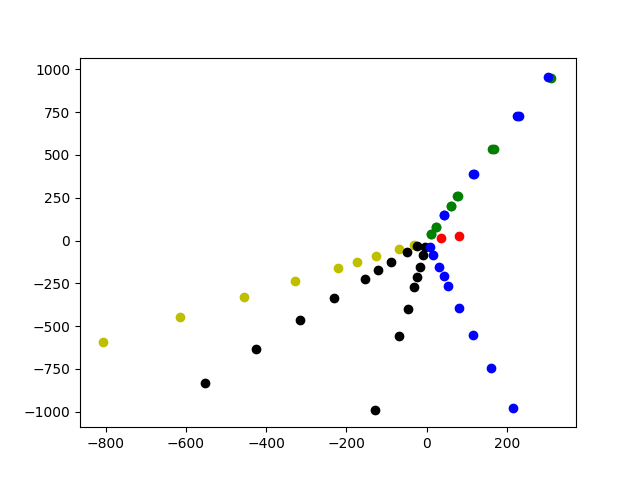

In [18]:
cmap = ['k','b','y','g','r']
for itrack in np.unique(tracks):
    if itrack >= 0:
        hits_track = (tracks == itrack)
        plt.scatter(pixelx[hits_track],pixely[hits_track],color=cmap[int(itrack) % 5])
plt.show()

Let's see which hits were not assigned to any cluster:

In [19]:
cmap = ['k','b','y','g','r']
itrack = -1
hits_track = (tracks == itrack)
plt.scatter(pixelx[hits_track],pixely[hits_track],color=cmap[int(itrack) % 5])
plt.show()

### Scoring the assignment

**TODO**: move this helper code into a module

The score function measures the fraction of hits with good track assignment. More precisely, it is the overlap fraction between the true vs predicted cluster_id, averaged over all events. However, notice that the reconstruction algorithm has the freedom to label the indices in a way different than the true cluster_ids, therefore the "overlap" should be more clearly defined.

For this, we first determine a one-to-one matching between the true cluster_ids and predicted cluster_ids, particle-by-particle for a given event. For a given particle (defined by a single true cluster_id) the corresponding predicted cluster_id is the most frequent one among its hits. 

Once every particle is associated to a track in this way, we loop over to remove the duplicates, i.e. the tracks which contain the maximum hits of more than one particle. Among those particles, the particle with the most hits inside this track is considered to be the right match, and the other particles are considered to be lost.

After the above procedure, the well-associated hits in the event are counted, and their ratio to the total number of hits is determined as the efficiency of this event.

In the end, every event, regardless of its hit multiplicity, is considered equivalent and the efficiency is averaged over the events in the full sample.

The input to the score function is the true and predicted arrays of [event_id, cluster_id]. Note that in order for the scoring to function, the order of the hits in the predicted array must match exactly the same order in the input. If your algorithm reshuffles the order of the hits, make sure you save the original indices before doing that, and re-sort the result array corresponding to those indices.

In [20]:
def score_function(y_true, y_pred):
    '''Compute a clustering score.

    Cluster ids should be nonnegative integers. A negative integer
    will mean that the corresponding point does not belong to any
    cluster.

    We first identify assigned clusters by taking the max count of 
    unique assigned ids for each true cluster. We remove all unassigned
    clusters (all assigned ids are -1) and all duplicates (the same
    assigned id has majority in several true clusters) except the one
    with the largest count. We add the counts, then divide by the number
    of events. The score should be between 0 and 1. 

    Parameters
    ----------
    y_true : np.array, shape = (n, 2)
        The ground truth.
        first column: event_id
        second column: cluster_id
    y_pred : np.array, shape = (n, 2)
        The predicted cluster assignment.
        first column: event_id
        second column: predicted cluster_id
    """
    '''
    score = 0.
    event_ids = y_true[:, 0]
    y_true_cluster_ids = y_true[:, 1]
    y_pred_cluster_ids = y_pred

    unique_event_ids = np.unique(event_ids)
    for event_id in unique_event_ids:
        event_indices = (event_ids==event_id)
        cluster_ids_true = y_true_cluster_ids[event_indices]
        cluster_ids_pred = y_pred_cluster_ids[event_indices]

        unique_cluster_ids = np.unique(cluster_ids_true)
        n_cluster = len(unique_cluster_ids)
        n_sample = len(cluster_ids_true)

        # assigned_clusters[i] will be the predicted cluster id
        # we assign (by majority) to true cluster i 
        assigned_clusters = np.empty(n_cluster, dtype='int64')
        # true_positives[i] will be the number of points in 
        # predicted cluster[assigned_clusters[i]]
        true_positives = np.full(n_cluster, fill_value=0, dtype='int64')
        for i, cluster_id in enumerate(unique_cluster_ids):
            # true points belonging to a cluster
            true_points = cluster_ids_true[cluster_ids_true == cluster_id]
            # predicted points belonging to a cluster
            found_points = cluster_ids_pred[cluster_ids_true == cluster_id]
            # nonnegative cluster_ids (negative ones are unassigned)
            assigned_points = found_points[found_points >= 0]
            # the unique nonnegative predicted cluster ids on true_cluster[i]
            n_sub_cluster = len(np.unique(assigned_points))
            # We find the largest predicted cluster in the true cluster.
            if(n_sub_cluster > 0):
                # sizes of predicted assigned cluster in true cluster[i]
                predicted_cluster_sizes = np.bincount(
                    assigned_points.astype(dtype='int64'))
                # If there are ties, we assign the tre cluster to the predicted
                # cluster with the smallest id (combined behavior of np.unique
                # which sorts the ids and np.argmax which returns the first 
                # occurence of a tie).
                assigned_clusters[i] = np.argmax(predicted_cluster_sizes)
                true_positives[i] = len(
                    found_points[found_points == assigned_clusters[i]])
            # If none of the assigned ids are positive, the cluster is unassigned
            # and true_positive = 0
            else:
                assigned_clusters[i] = -1
                true_positives[i] = 0

        # resolve duplicates and count good assignments
        sorted = np.argsort(true_positives)
        true_positives_sorted = true_positives[sorted]
        assigned_clusters_sorted = assigned_clusters[sorted]
        good_clusters = assigned_clusters_sorted >= 0
        for i in range(len(assigned_clusters_sorted) - 1):
            assigned_cluster = assigned_clusters_sorted[i]
            # duplicates: only keep the last count (which is the largest
            # because of sorting)
            if assigned_cluster in assigned_clusters_sorted[i+1:]:
                good_clusters[i] = False
        n_good = np.sum(true_positives_sorted[good_clusters])
        score += 1. * n_good / n_sample
    score /= len(unique_event_ids)
    return score


Check the score of a single event:

In [21]:
y_pred = np.zeros((len(y_predicted),2))

y_pred[:,1] = y_predicted
y_pred[:,0] = [ievent] * len(y_predicted)

y_test_event = y[y[:,0]==ievent]

score_function(y_test_event,y_pred)

0.7454545454545455